In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# SPLITTING UP THE DATA HERE BASED ON A TSA APPROACH
### Other of our explorations might work slightly differently, if we do a prediction model or topic modeling

In [2]:
# df = pd.read_csv('npr_corpus.csv')
# df.head()

In [3]:
# use our own wrangle to get the data
df = wrangle.get_npr_data()
df.head()

The df has 1889857 rows and 12 columns.


,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [4]:
df.shape

(1889851, 11)

In [5]:
df.speaker.value_counts()

neal conan            255146
ira flatow             73209
steve inskeep          59565
robert siegel          49750
melissa block          39983
                       ...  
alessandro gilioli         1
mr. mark zalona            1
caroline hawkins           1
gerecht                    1
mr. glen frazier           1
Name: speaker, Length: 105417, dtype: int64

In [6]:
# df.sort_values(by=['episode_id','episode_order'])[0:50]
df.sort_values(by=['story_id_num','utterance_order'])[0:50]

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
13231,17,1,melissa block,He is in cahoots with a foreign government to ...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,he is in cahoots with a foreign government to ...,he is in cahoot with a foreign government to m...,-0.8176,2019-09-22
13232,17,2,melissa block,Let's hear now from another Democrat. Tom Mali...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,let s hear now from another democrat. tom mali...,let s hear now from another democrat. tom mali...,0.4404,2019-09-22
13233,17,3,tom malinowski,Good morning.,weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,good morning .,good morning .,0.4404,2019-09-22
13234,17,4,melissa block,I'd like first to get your response to the Tru...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,i d like first to get your response to the tru...,i d like first to get your response to the tru...,0.3612,2019-09-22
13235,17,5,tom malinowski,"Well, first of all, it's illegal. We have a ve...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"well , first of all , it s illegal. we have a ...","well , first of all , it s illegal. we have a ...",0.8680,2019-09-22
13236,17,6,melissa block,"Now, we should explain that this has to do, ac...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"now , we should explain that this has to do , ...","now , we should explain that this ha to do , a...",0.5106,2019-09-22
13237,17,7,tom malinowski,"Look. I think there is a very, very big leap b...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"look. i think there is a very , very big leap ...","look. i think there is a very , very big leap ...",0.7783,2019-09-22
13238,17,8,melissa block,"And you say, if it's true...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"and you say , if it s true ...","and you say , if it s true ...",0.4215,2019-09-22
13239,17,9,tom malinowski,"And yes, impeachable.",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"and yes , impeachable .","and yes , impeachable .",0.4019,2019-09-22
13240,17,10,melissa block,"You say, if it's true, what powers does the Ho...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"you say , if it s true , what powers does the ...","you say , if it s true , what power doe the ho...",0.4215,2019-09-22


## Ok, since we already have utterance order, we can just use that as a feature
## Moving on to utterance length

In [7]:
df.utterance[0]

"It's a 2,200-mile race. To give some sense of perspective, that's roughly the distance between Washington, D.C. and Las Vegas. They do it over the course of three weeks at very fast speeds. But incredibly, oftentimes the distance between first and second is somewhere between and one and three minutes."

In [8]:
len(df.utterance[0])

302

In [9]:
len(df.utterance[0].split())

50

In [10]:
# df.utterance.apply(str.split).apply(len)[0]

In [11]:
# Create a word count for every utterance
df['utterance_word_count'] = df.utterance.apply(str.split).apply(len)
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12,50
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12,87
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12,33
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12,118
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12,10


#### A quick lesson on .apply:

In [12]:
# def make_wordcloud(host):
#     etc etc

# h.apply(make_wordcloud)

# the h is what is referred to after the apply is applied

# or

# def make_wordcloud(host, ajowpj):
#     etc etc

# h.apply(make_wordcloud, extr_words= blah blah)

In [13]:
def string_cleaning(s):
    '''
    Function to remove punctuation from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z0-9'\s\?]", '', s)

    return s

In [14]:
df.utterance[2]

"So in every team, presumably there's one star, one equivalent to Lance Armstrong and the other team - the rest of the teammates project him, do what they can to help him succeed?"

In [15]:
# Identify the presence of a question mark...how about a question mark count?

df.utterance.str.contains(r"[\?]", regex=True)[2]

True

In [16]:
# get a questino mark couont foor  iloc [2]

df.utterance.str.count(r"[\?]")[2]

1

In [17]:
# creat a questioon mark coouont column
df['question_mark_count'] = df.utterance.str.count(r"[\?]")
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count,question_mark_count
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12,50,0
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12,87,0
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12,33,1
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12,118,0
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12,10,1


## Who asks the most questions?

In [18]:
# Extract the total number of question marks for every given speaker, display top ten
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,speaker,count
81830,neal conan,255146
29199,ira flatow,73209
98098,steve inskeep,59565
91806,robert siegel,49750
46070,melissa block,39983
89616,renee montagne,37241
23679,farai chideya,36719
94514,scott simon,33394
88612,rachel martin,31292
15210,david greene,30419


-  As can be seen, Neal Conan has asked overr 250_000 questions on air!
-  Thats over 3 times the number two host in questions
- Conan hosted talk of the nation, a two-hour daily interview program for years
- Flatow hosted and still hosts Science Friday, a weekly interview program that started as a spinoff of Talk of the Nation

In [19]:
# create a question mark count df fromo the above code
questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [20]:
# merge it with the whole df no speaker for viz purposes below
questions = questions.merge(df, how='left', on='speaker').drop(columns=['story_id_num', 'utterance_order', 'utterance',
       'title','clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'])
questions

,speaker,count,program,is_host,date
0,neal conan,255146,talk of the nation,True,2010-07-12
1,neal conan,255146,talk of the nation,True,2010-07-12
2,neal conan,255146,talk of the nation,True,2010-07-12
3,neal conan,255146,talk of the nation,True,2010-07-12
4,neal conan,255146,talk of the nation,True,2010-07-12
...,...,...,...,...,...
1889846,mr. jeff lipman,1,morning edition,False,2006-08-31
1889847,anne larigauderie,1,morning edition,False,2019-05-07
1889848,james delong,1,morning edition,False,2007-05-07
1889849,james delapp,1,morning edition,False,2017-10-11


Text(0, 0.5, 'Count of Questions')

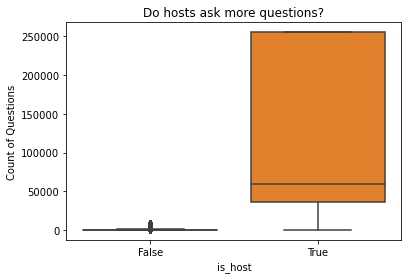

In [21]:
#seaborn boxplot for uqestion count by is_host == True or False
sns.boxplot(data= questions, x= 'is_host',y='count')
plt.title("Do hosts ask more questions?")
plt.ylabel("Count of Questions")

- Our visual provides ample proof that hosts ask far moroe questions than guests

## Is there a difference in the mean sentiment by speaker? Program? etc
- Applied statistics-> i.e. stats testing. Is there a difference in the mean sentiment by speaker? Program? etc 

In [22]:
df.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader', 'date',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [23]:
df.shape

(1889851, 13)

In [24]:
df.dtypes

story_id_num              int64
utterance_order           int64
speaker                  object
utterance                object
program                  object
title                    object
is_host                    bool
clean                    object
lemmatized               object
vader                   float64
date                     object
utterance_word_count      int64
question_mark_count       int64
dtype: object

In [25]:
# make sure teh date column is in pandas daateetime format
df.date = pd.to_datetime(df.date)

In [26]:
df.dtypes

story_id_num                     int64
utterance_order                  int64
speaker                         object
utterance                       object
program                         object
title                           object
is_host                           bool
clean                           object
lemmatized                      object
vader                          float64
date                    datetime64[ns]
utterance_word_count             int64
question_mark_count              int64
dtype: object

In [27]:

# df['Date'].dt.strftime('%b-%Y')

# df['episode_date'].dt.strftime('%b')

In [28]:
# df['month']=df['date'].dt.strftime('%b')
# df['year']=pd.DatetimeIndex(df['date']).year
# df=df.reset_index()
# df.head()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# set datee to index
df=df.set_index('date').sort_index()

In [31]:
# df = df[df.index.year >= 2005] 
# we already  limited the data to psot-2005

In [32]:
df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,87,neal conan,Mm-hmm.,talk of the nation,difference between a think and a 'blink',True,mm hmm .,mm hmm .,0.0,1,0


In [33]:
# Time-series analysis split
train = df[:'2015']
validate = df['2016':'2017']
test = df['2018':]
train.shape, validate.shape, test.shape

((1665125, 12), (129513, 12), (95213, 12))

In [34]:
# checking all ouor splits are adjacent to each other
train.index[-1:], validate.index[:1], validate.index[-1:], test.index[:1]

(DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2016-01-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2017-12-29'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='date', freq=None))

<AxesSubplot:>

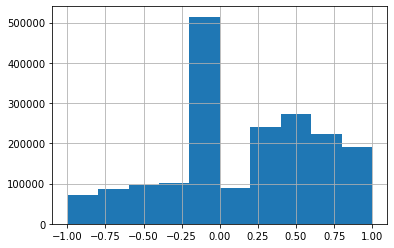

In [35]:
# histogram of vader sentiment scores
df.vader.hist()

- The histogram hints at two groups: a highly neutral host group and a somewhat more optimistic guests group

## Using train split from here
##  This is mainly a tsa look

In [36]:
# create a df fro hosts only
host_df = train[train.is_host==True]

In [37]:
# create a df fro gueests only
guest_df = train[train.is_host!=True]

In [38]:
host_df.shape, guest_df.shape

((641015, 12), (1024110, 12))

In [39]:
host_df.shape

(641015, 12)

In [40]:
# are there repeats in the host_df? 
host_df.speaker.value_counts()

neal conan          255146
ira flatow           73209
robert siegel        43958
steve inskeep        41789
melissa block        38922
                     ...  
michelle block           6
ray suarez               5
joost hiltermann         4
robert seigel            4
alison stewart           1
Name: speaker, Length: 86, dtype: int64

- I can see two different duplicates for steve inskeep bc of typos
- I think this is going to fall into the arena of significantly diminishing returns, and I will not address it at this time

In [41]:
# a list of the 10 hosots with the most observations
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

- This is a list of the 12 hosts with the most observations

In [42]:
hosts_with_the_most

['neal conan',
 'ira flatow',
 'robert siegel',
 'steve inskeep',
 'melissa block',
 'farai chideya',
 'renee montagne',
 'scott simon',
 'david greene',
 'rachel martin']

In [43]:
# limits the overal df to. only thee hosts_with_the_most
top_hosts_df = train[train.speaker.isin(hosts_with_the_most)]


In [44]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,87,neal conan,Mm-hmm.,talk of the nation,difference between a think and a 'blink',True,mm hmm .,mm hmm .,0.0,1,0


In [45]:
top_hosts_df.index.min(), top_hosts_df.index.max()

(Timestamp('2005-01-11 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [46]:
# avg sentiment score for the top hosts
top_hosts_df.vader.mean()

0.15754095375685997

- Here, we have the average sentiment score for all the top hosts; as you can see, it is relatively neutral in sentiment

In [186]:
top_hosts_df[top_hosts_df.speaker == 'farai chideya'].vader.mean()

0.18528189290298422

In [47]:
top_hosts_df[top_hosts_df.speaker == 'rachel martin'].vader.mean()

0.21158963585433688

In [48]:
top_hosts_df.vader.mean()

0.15754095375685997

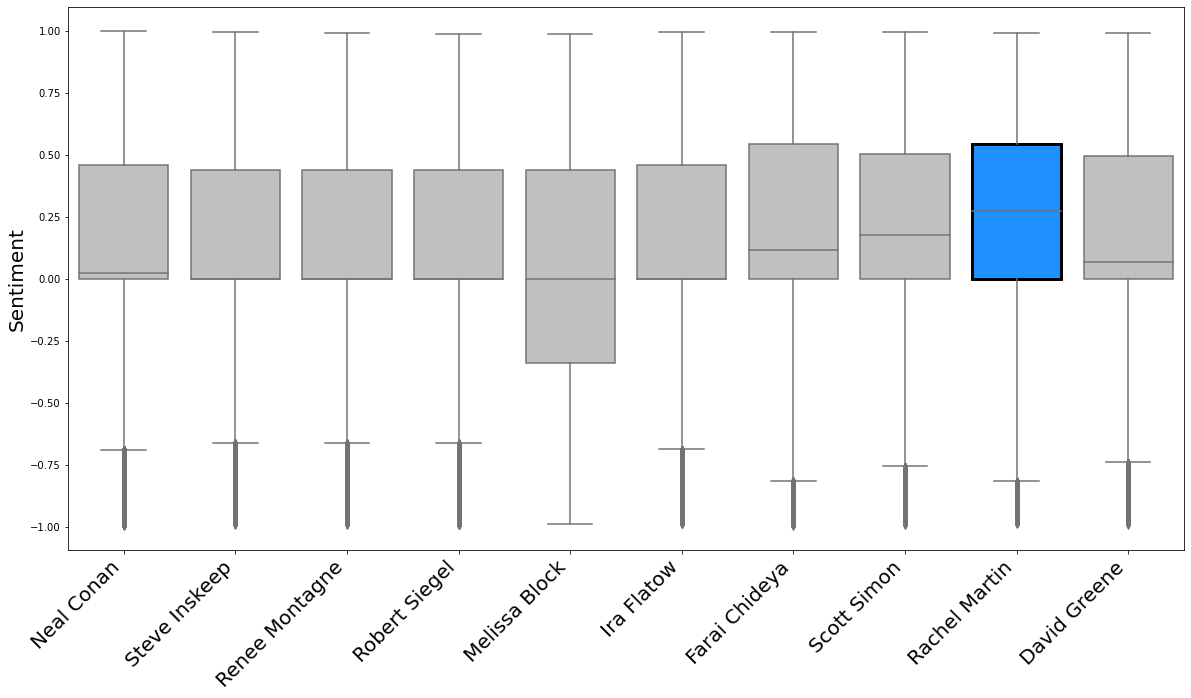

In [185]:
# sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
    


ax = sns.boxplot(x="speaker", y="vader",data=top_hosts_df, color='silver')# palette="Set3")

# Select which box you want to change

mybox = ax.artists[8]

# Change the appearance of that box
# ax.artists[:].set_facecolor('green')
mybox.set_facecolor('dodgerblue')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('',fontsize=(20),weight=(10))
plt.xticks(rotation=45, fontsize=(20), ha = 'right', ticks = [0,1,2,3,4,5,6,7,8,9],
          labels = ['Neal Conan', 'Steve Inskeep', 'Renee Montagne', 'Robert Siegel',
       'Melissa Block', 'Ira Flatow', 'Farai Chideya', 'Scott Simon',
       'Rachel Martin', 'David Greene'])
plt.savefig("host_sentiment")
plt.show()

- All  of our top hosts are quite netural on the Vader index, although some rate higher
    - Scott Simon, for instance, who hosts a weekend program
    - Rachel Martin  bucks the trends: she co-hosts Morning Edition, a weekday daily with a lower average sentiment score overall
    - Stoic Melissa Block has the lowestvader score, and hosted All Things Considered for years, a daily afternoon news/politics program
- The mean sentiment value is awfully close for everyone here, so we stats test it with an ANOVA test next

In [50]:
# Creeate a null and alt hypothesis for stats testing
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [51]:
# just to create df names fro all the hosts
host_df_list=[]
for host in hosts_with_the_most:
    x = host.split()
    host_df_list.append(f'{x[0]}_df')
print(host_df_list)

['neal_df', 'ira_df', 'robert_df', 'steve_df', 'melissa_df', 'farai_df', 'renee_df', 'scott_df', 'david_df', 'rachel_df']


In [52]:
hosts_with_the_most

['neal conan',
 'ira flatow',
 'robert siegel',
 'steve inskeep',
 'melissa block',
 'farai chideya',
 'renee montagne',
 'scott simon',
 'david greene',
 'rachel martin']

In [53]:
# Let's isolate our hosts foro stats testing
NEAL_df = train[train.speaker == 'neal conan'].vader
IRA_df = train[train.speaker ==  'ira flatow'].vader
ROBERT_df = train[train.speaker == 'robert siegel'].vader
STEVE_df = train[train.speaker == 'steve inskeep'].vader
MELISSA_df = train[train.speaker == 'melissa block'].vader
FARAI_df = train[train.speaker ==  'farai chideya'].vader
RENEE_df = train[train.speaker == 'renee montagne'].vader
SCOTT_df = train[train.speaker == 'scott simon'].vader
DAVID_df = train[train.speaker == 'david greene'].vader
RACHEL_df = train[train.speaker == 'rachel martin'].vader

# in pervious iterations but changed as the data got more wrangled:

# GUY_df = train[train.speaker == 'guy raz, host'].vader_stopped
# MADELEINE_df = train[train.speaker == 'madeleine brand, host'].vader_stopped
# MICHELE_df = train[train.speaker == 'michelle norris, host'].vader_stopped
# ALEX_df = train[train.speaker == 'alex chadwick, host'].vader_stopped


In [54]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(NEAL_df, IRA_df, ROBERT_df, STEVE_df, MELISSA_df, FARAI_df, RENEE_df, SCOTT_df, DAVID_df, RACHEL_df)
f, p

(678.8558843077727, 0.0)

In [55]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


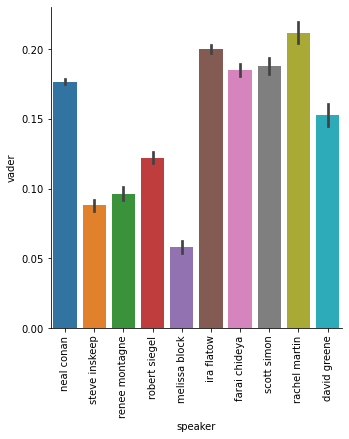

In [56]:
# another view of sentiment score by hosts
sns.catplot(x="speaker", y="vader", kind="bar", data=top_hosts_df)
plt.xticks(rotation=90);

- Another view of the same...it looks more clear here that there is a difference, however note the small scale on the y axis
- Ira Flatow's energetic personality shows through in this graph

In [57]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,87,neal conan,Mm-hmm.,talk of the nation,difference between a think and a 'blink',True,mm hmm .,mm hmm .,0.0,1,0


### The conclusion to the above is that there is a statistically significant difference in sentiment in the top hosts group, even if it is small.

### Josh's code for the hosts' words

In [58]:
# host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['lemmatized'].agg(lambda col: ' '.join(col))

## Word count for speakers vs hosts

In [59]:
train.utterance_word_count.mean()

35.782547256212

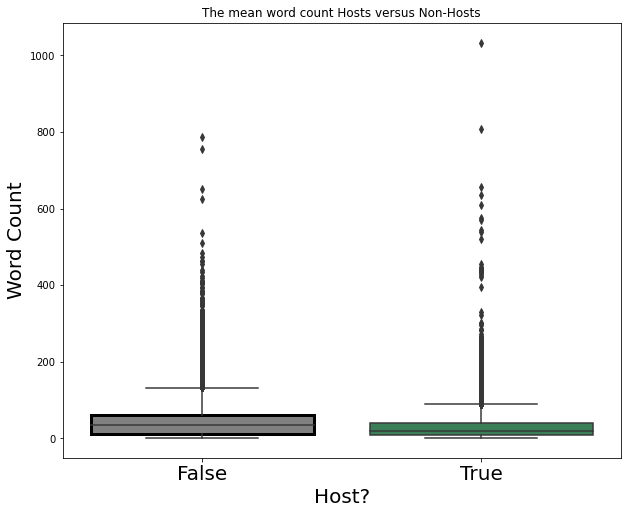

In [60]:
# plot vader score for hosts versus not


# sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
    
ax = sns.boxplot(data=train, x='is_host',y='utterance_word_count', color = 'seagreen')
# Select which box you want to change

mybox = ax.artists[0]

# Change the appearance of that box
# ax.artists[:].set_facecolor('green')
mybox.set_facecolor('gray')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)
plt.title("The mean word count Hosts versus Non-Hosts")
plt.ylabel('Word Count',fontsize=(20))
plt.xlabel('Host?',fontsize=(20),weight=(10))
plt.xticks(rotation=0, fontsize=(20))
plt.savefig("Host_vs_non")
plt.show()

In [61]:
train[train.is_host == True].utterance_word_count.mean()

27.809572318900493

In [62]:
train[train.is_host == False].utterance_word_count.mean()

40.77302340568884

## Does order of utterance make a difference?

In [63]:
train[train.utterance_order==1].is_host.mean()

0.9879501385041551

# Only 98% of the time

## What's the difference in sentiment score between hosts and non-hosts?

In [64]:
# creat a non-host df
non_host_df = train[train.is_host==False]

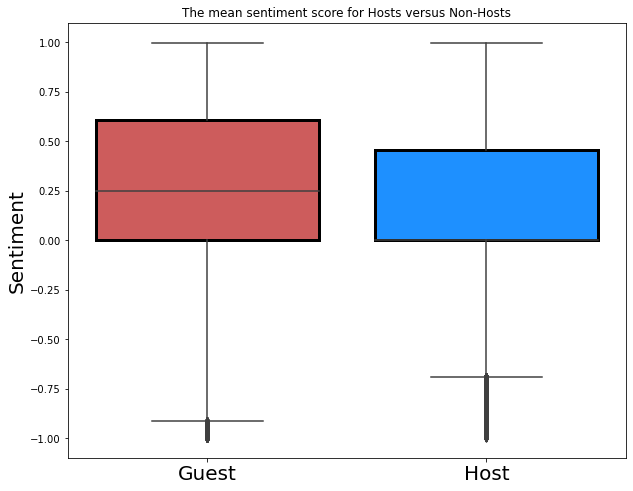

In [157]:
# plot vader score for hosts versus not
# labels = ['Guest', 'Host'], colors = ['indianred','dodgerblue']

# sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
    
ax = sns.boxplot(data=train, x='is_host',y='vader')#, labels = labels)
# Select which box you want to change

# mybox = ax.artist[1]
mybox0 = ax.artists[0]
mybox1 = ax.artists[1]
# Change the appearance of that box
# ax.artists[:].set_facecolor('green')
mybox0.set_facecolor('indianred')
mybox0.set_edgecolor('black')
mybox0.set_linewidth(3)
mybox1.set_facecolor('dodgerblue')
mybox1.set_edgecolor('black')
mybox1.set_linewidth(3)
plt.title("The mean sentiment score for Hosts versus Non-Hosts")
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('',fontsize=(20),weight=(10))
plt.xticks(rotation=0, fontsize=(20),ticks=[0,1],labels=['Guest', 'Host'])
# plt.savefig("Host_vs_non")
plt.show()

- NPR hosts tend to keep it neutral in the sentiment department

In [66]:
train[train.is_host==False].vader.mean(), train[train.is_host==True].vader.mean()

(0.19270630908800554, 0.1528444529378991)

In [67]:
# Creeate a null and alt hypothesis for stats testing
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [68]:
#stats testing on the same
# anova is the wrong test! ttest in  this case, independent variety
from scipy import stats

t, p = stats.ttest_ind(host_df.vader,non_host_df.vader)
t, p

(-52.76629341497047, 0.0)

In [69]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


### The average sentiment score for non-hosts is somewhat higher than for the hosts.  To be expected for a relatively neutral news outlet?

## How about sentiment score by year?

In [70]:
# resample vader score by year
train.resample('Y').vader.mean()

date
2005-12-31    0.169318
2006-12-31    0.161386
2007-12-31    0.180956
2008-12-31    0.209604
2009-12-31    0.193803
2010-12-31    0.184555
2011-12-31    0.172065
2012-12-31    0.188927
2013-12-31    0.157618
2014-12-31    0.131946
2015-12-31    0.139144
Freq: A-DEC, Name: vader, dtype: float64

- why don't we have vader scores in 2000-2003 on yearly resampling?

In [71]:
# create yearly  vader df based on train
vader_yearly = pd.DataFrame(train.resample('Y').vader.mean())

<AxesSubplot:xlabel='date'>

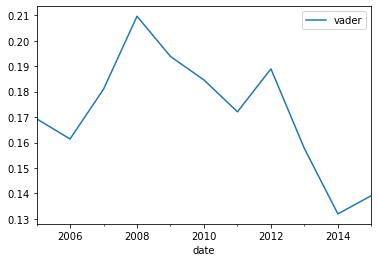

In [72]:
# and plot
vader_yearly.plot()

- There doesn't appear to be a trend to speak of

In [73]:
# create yearly  vader df based on wholee df
whole_df_yearly = pd.DataFrame(df.resample('Y').vader.mean())

<AxesSubplot:xlabel='date'>

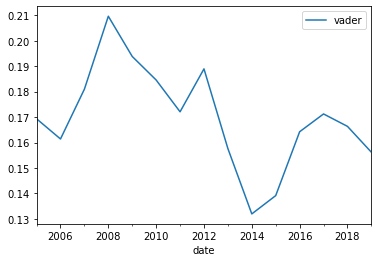

In [74]:
# and plot
whole_df_yearly.plot()

In [75]:
# create monthly  vader df based on train
vader_monthly = pd.DataFrame(train.resample('M').vader.mean())

In [76]:
vader_monthly.head()

,vader
date,
2005-01-31,0.272687
2005-02-28,NaN
2005-03-31,NaN
2005-04-30,NaN
2005-05-31,0.176331


<AxesSubplot:xlabel='date'>

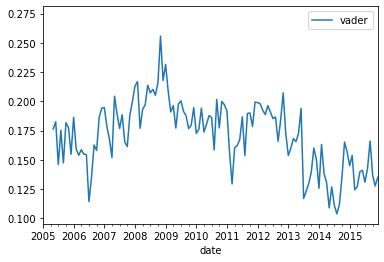

In [77]:
#and ploot
vader_monthly.plot()

- Still, no real trend is detectable

In [78]:
# pd.DataFrame(df.resample("d").vader_stopped.mean()).plot()

<AxesSubplot:xlabel='date'>

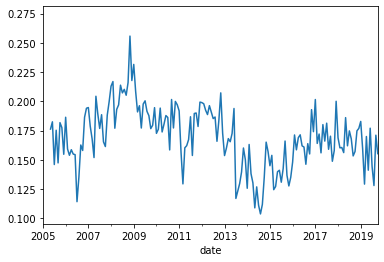

In [79]:
df.resample('M').vader.mean().plot()

In [80]:
df.vader.idxmax()

Timestamp('2015-12-28 00:00:00')

In [81]:
df[df.index=='2015-12-28'].title.unique()

array(['training the immune system to fight cancer has 19th-century roots',
       'school testing 2016: same tests, different stakes',
       'artist ellsworth kelly, master of colorful abstraction, dies at 92',
       'tornado victims in north texas recall train sound as they sought shelter\n                                    <b class="program-segment__organization">kera</b>',
       'paid family leave gains ground for private, public sector workers',
       'president obama has a question for his successor',
       'many regions hit with severe weather over holiday weekend',
       "inmate allowed to compete in tv's 'voice of georgia'"],
      dtype=object)

## By day of week?

In [82]:
train.index.day_name()

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Thursday', 'Thursday', 'Thursday', 'Thursday', 'Thursday', 'Thursday',
       'Thursday', 'Thursday', 'Thursday', 'Thursday'],
      dtype='object', name='date', length=1665125)

In [83]:
# sentiment score by  day of week
train.groupby(train.index.day_name()).vader.mean()
# sentiment by day, 0 is monday, 6 is sunday

date
Friday       0.197643
Monday       0.167613
Saturday     0.182299
Sunday       0.200146
Thursday     0.173885
Tuesday      0.166035
Wednesday    0.176345
Name: vader, dtype: float64

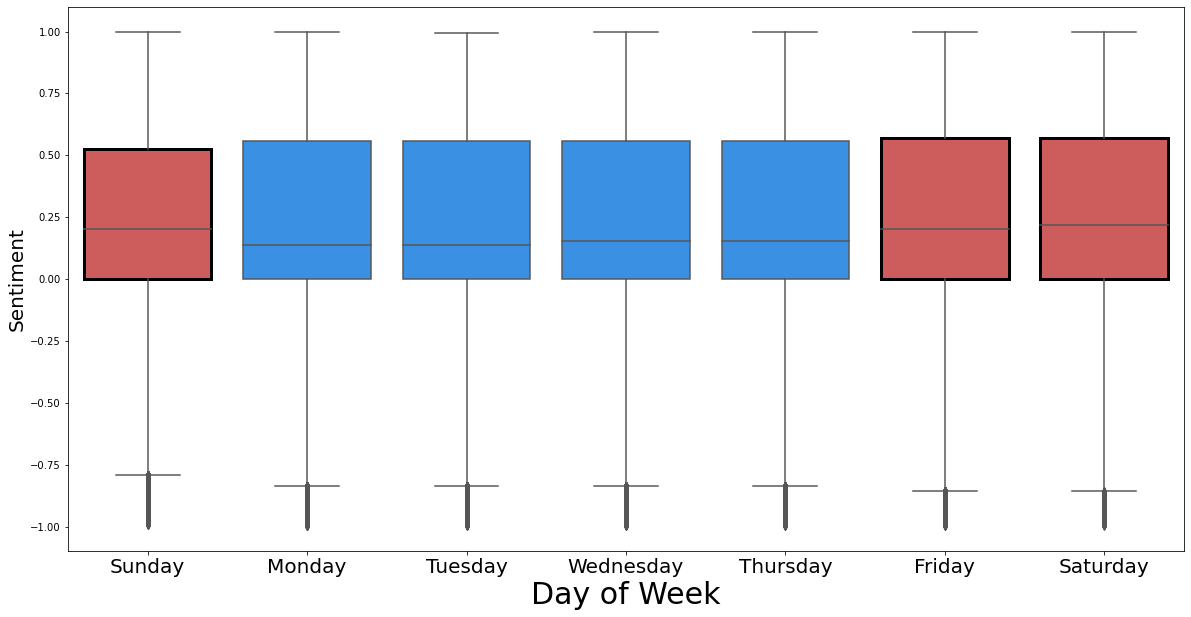

In [148]:
# plot and order the avg sentiment score by day of week
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=train, x=train.index.day_name(),y='vader', order=order, color='dodgerblue')

# Select which box you want to change

mybox0 = ax.artists[0]
mybox6 = ax.artists[5]
mybox7 = ax.artists[6]
# Change the appearance of that box
# ax.artists[:].set_facecolor('green')
mybox0.set_facecolor('indianred')
mybox0.set_edgecolor('black')
mybox0.set_linewidth(3)
mybox6.set_facecolor('indianred')
mybox6.set_edgecolor('black')
mybox6.set_linewidth(3)
mybox7.set_facecolor('indianred')
mybox7.set_edgecolor('black')
mybox7.set_linewidth(3)
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('Day of Week',fontsize=(30),weight=(10))
plt.xticks(rotation=0, fontsize=(20))
# plt.savefig("host_sentiment")
plt.show()







In [85]:
# # plot and order the avg sentiment score by day of week
# order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# plt.figure(figsize=(10,6))
# sns.boxplot(data=train, x=train.index.day_name(),y='vader', order=order)

- The  impression is  that sentiment is a little higher on the weekend, dipping Mondays and rising Fridays into the weekend

In [86]:
# creat  dfs for each day fo the  week
# 0 is monday, 6 is sunday
Monday_df = train[train.index.weekday == 0]
Tuesday_df = train[train.index.weekday == 1]
Wednesday_df = train[train.index.weekday == 2]
Thursday_df = train[train.index.weekday == 3]
Friday_df = train[train.index.weekday == 4]
Saturday_df = train[train.index.weekday == 5]
Sunday_df = train[train.index.weekday == 6]

In [87]:
# define hypotheses
null_hypothesis = "Different days of the week have the same sentiment score"
alternative_hypothesis = "At least one day of the week has a different sentiment score from the rest"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [88]:
# run the test, an an anova in this case
from scipy.stats import f_oneway

f, p = f_oneway(Monday_df.vader,\
Tuesday_df.vader,\
Wednesday_df.vader,\
Thursday_df.vader,\
Friday_df.vader,\
Saturday_df.vader,\
Sunday_df.vader)

f, p

(167.5130744190092, 8.286027834016031e-214)

In [89]:
# return the result
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from one weekday to the next")

We reject the null hypothesis that Different days of the week have the same sentiment score
We move forward with the alternative hypothesis that At least one day of the week has a different sentiment score from the rest


## And by program?

In [90]:
# what are the different programs?
train.program.value_counts().index.to_list()

['talk of the nation',
 'morning edition',
 'all things considered',
 'news & notes',
 'weekend edition saturday',
 'weekend edition sunday',
 'day to day']

In [91]:
#  creat a df for each program
Talk_of_the_Nation_df = train[train.program == 'talk of the nation']
Morning_Edition_df = train[train.program == 'morning edition']
All_Things_Considered_df = train[train.program == 'all things considered']
News_and_Notes_df = train[train.program == 'news & notes']
Weekend_Edition_Saturday_df = train[train.program == 'weekend edition saturday']
Weekend_Edition_Sunday_df = train[train.program == 'weekend edition sunday']
Day_to_Day_df = train[train.program == 'day to day']


In [164]:
train.program.unique().tolist()

['talk of the nation',
 'morning edition',
 'all things considered',
 'news & notes',
 'weekend edition saturday',
 'day to day',
 'weekend edition sunday']

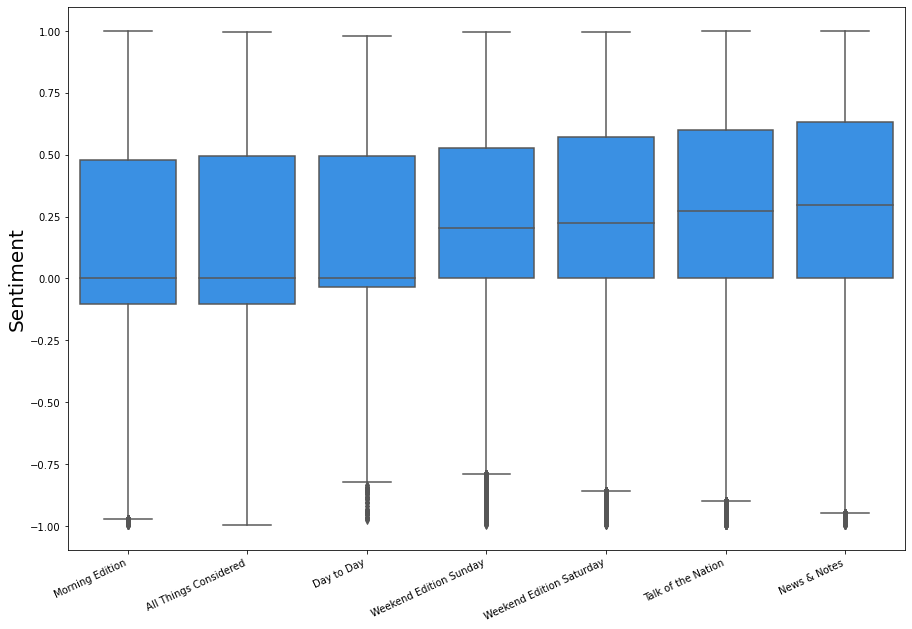

In [182]:
# plot and order the avg sentiment score by day of week
order = ['morning edition', 'all things considered', 'day to day', 'weekend edition sunday', \
         'weekend edition saturday', 'talk of the nation', 'news & notes']
label_list = ['Morning Edition',
 'All Things Considered',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday',
 'Talk of the Nation',
 'News & Notes']
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=train, x='program',y='vader',order=order,color='dodgerblue')
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('',fontsize=(30),weight=(10))
plt.xticks(rotation=25, fontsize=(10), ha='right', ticks=[0,1,2,3,4,5,6], labels = label_list);
plt.show();

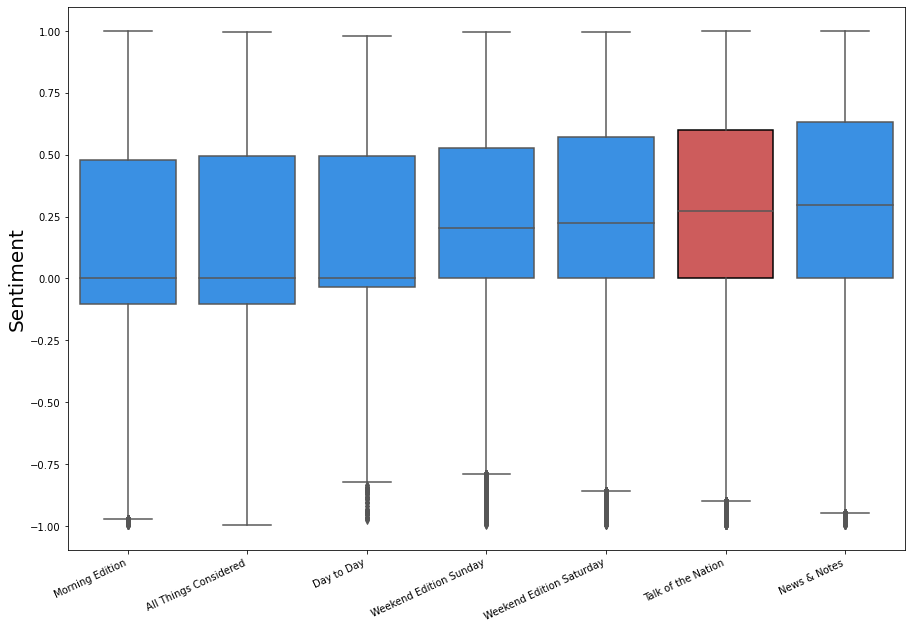

In [181]:
# plot and order the avg sentiment score by day of week
order = ['morning edition', 'all things considered', 'day to day', 'weekend edition sunday', \
         'weekend edition saturday', 'talk of the nation', 'news & notes']
label_list = ['Morning Edition',
 'All Things Considered',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday',
 'Talk of the Nation',
 'News & Notes']
 

plt.figure(figsize=(15,10))
ax = sns.boxplot(data=train, x='program',y='vader',order=order,color='dodgerblue')

mybox0 = ax.artists[0]
mybox1 = ax.artists[1]
mybox3 = ax.artists[3]
mybox4 = ax.artists[4]
mybox5 = ax.artists[5]
# mybox0.set_facecolor('indianred')
# mybox0.set_edgecolor('black')
# # mybox0.set_linewidth(3)
# mybox1.set_facecolor('indianred')
# mybox1.set_edgecolor('black')
# # mybox1.set_linewidth(3)
# mybox3.set_facecolor('indianred')
# mybox3.set_edgecolor('black')
# # mybox3.set_linewidth(3)
# mybox4.set_facecolor('indianred')
# mybox4.set_edgecolor('black')
# mybox4.set_linewidth(3)
mybox5.set_facecolor('indianred')
mybox5.set_edgecolor('black')
# mybox5.set_linewidth(3)
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('',fontsize=(30),weight=(10))
plt.xticks(rotation=25, fontsize=(10), ha='right', ticks=[0,1,2,3,4,5,6], labels = label_list);
plt.show();

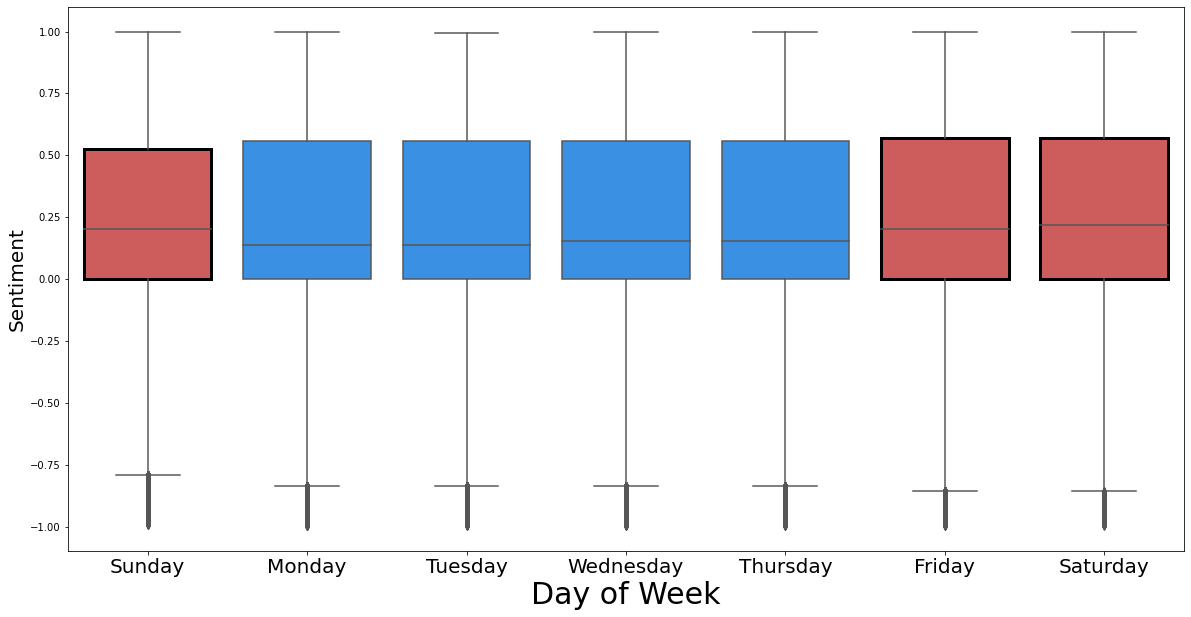

In [148]:
# plot and order the avg sentiment score by day of week
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=train, x=train.index.day_name(),y='vader', order=order, color='dodgerblue')

# Select which box you want to change

mybox0 = ax.artists[0]
mybox6 = ax.artists[5]
mybox7 = ax.artists[6]
# Change the appearance of that box
# ax.artists[:].set_facecolor('green')
mybox0.set_facecolor('indianred')
mybox0.set_edgecolor('black')
mybox0.set_linewidth(3)
mybox6.set_facecolor('indianred')
mybox6.set_edgecolor('black')
mybox6.set_linewidth(3)
mybox7.set_facecolor('indianred')
mybox7.set_edgecolor('black')
mybox7.set_linewidth(3)
plt.ylabel('Sentiment',fontsize=(20))
plt.xlabel('Day of Week',fontsize=(30),weight=(10))
plt.xticks(rotation=0, fontsize=(20))
# plt.savefig("host_sentiment")
plt.show()







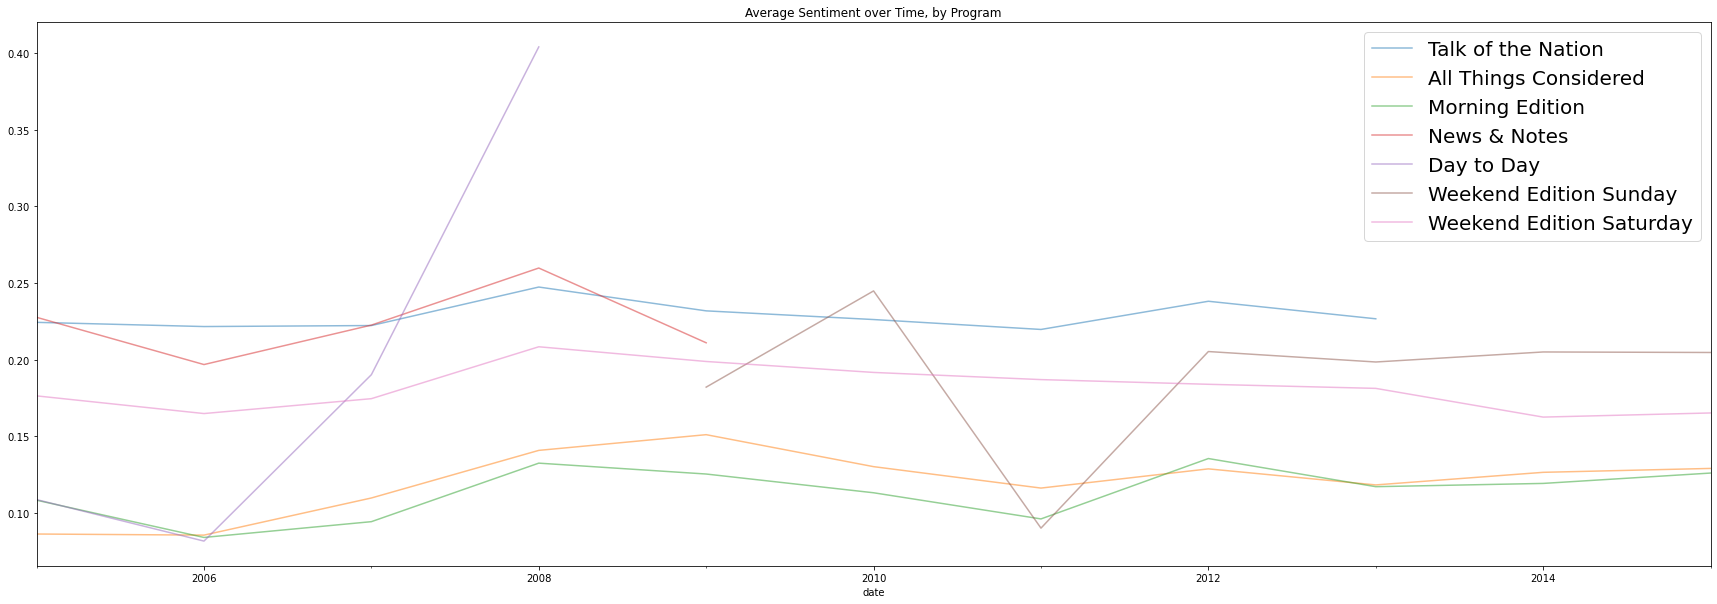

In [93]:
# plot the  sentimen over time of each program
plt.figure(figsize=(30,10))
Talk_of_the_Nation_df.resample("y").vader.mean().plot(alpha=.5)
All_Things_Considered_df.resample("y").vader.mean().plot(alpha=.5)
Morning_Edition_df.resample("y").vader.mean().plot(alpha=.5)
News_and_Notes_df.resample("y").vader.mean().plot(alpha=.5)
Day_to_Day_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Sunday_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Saturday_df.resample("y").vader.mean().plot(alpha=.5)
plt.title("Average Sentiment over Time, by Program")
plt.legend(['Talk of the Nation',
 'All Things Considered',
 'Morning Edition',
 'News & Notes',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday'], prop={'size': 20})

- Note the programs that have gone off air
- Also, there is some difference in sentiment from program to program
- Weekend Edition (Sat and Sun) have higher sentiment scores--these programs try to be a little on the lighter side for the weekend
- We're definitely starting off the day on the most pessimistic note
- (And ending it too... All Things Considered is the afternooon daily news/politics program)

In [94]:
# Define hyptoheses
null_hypothesis = "The different programs have the same sentiment score"
alternative_hypothesis = "At least one program has a different sentiment score"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [95]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(Talk_of_the_Nation_df.vader,
All_Things_Considered_df.vader,
Morning_Edition_df.vader,
News_and_Notes_df.vader,
Day_to_Day_df.vader,
Weekend_Edition_Sunday_df.vader,
Weekend_Edition_Saturday_df.vader,)
f, p

(3653.753690004038, 0.0)

In [96]:
# Return stats results
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that The different programs have the same sentiment score
We move forward with the alternative hypothesis that At least one program has a different sentiment score


## How did sentiment change after 9/11 or etc...
- after obama election? 
- from start to finish of 2016 presidential campaign?

## what about clustering?
### Please see Josh and my reespective noteebooks to the effect
### We built a cluster but determined it was not useeful for the model

In [97]:
train.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

# First...
- Let's do a tsa model of sentiment using Prophet : )
- See the prophet notebook, not pushed to github due to size

In [98]:
# build a df for tsa type modeling
for_tsa_modeling_df = pd.DataFrame(df['vader'])

In [99]:
for_tsa_modeling_df.head()

,vader
date,
2005-01-11,0.0000
2005-01-11,0.4019
2005-01-11,0.0000
2005-01-11,0.7906
2005-01-11,-0.8548


In [100]:
# years in df
for_tsa_modeling_df.index.year.value_counts()

2007    213708
2008    190843
2009    180095
2010    179387
2012    176305
2006    173052
2011    172819
2013    130009
2005    102972
2014     77886
2015     68049
2016     65271
2017     64242
2018     53154
2019     42059
Name: date, dtype: int64

In [101]:
# create splits
tsa_train = for_tsa_modeling_df['2005':'2015']
tsa_validate = for_tsa_modeling_df['2016':'2017']
tsa_test = for_tsa_modeling_df['2018':]
tsa_train.shape, tsa_validate.shape, tsa_test.shape

((1665125, 1), (129513, 1), (95213, 1))

In [102]:
# are the splits immediately adjacent?
tsa_train[-1:], tsa_validate[:1], tsa_validate[-1:], tsa_test[:1]

(             vader
 date              
 2015-12-31  0.7964,
              vader
 date              
 2016-01-01  0.4939,
              vader
 date              
 2017-12-29  0.4019,
              vader
 date              
 2018-01-01  0.6597)

- the splits look good

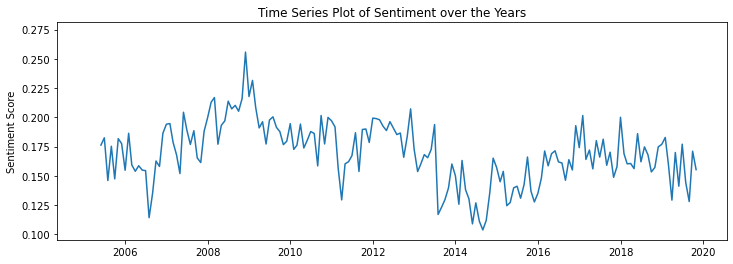

In [103]:
# a visualization of the three tsa splits
plt.figure(figsize=(12,4))
plt.plot(df.resample('M').vader.mean())

plt.ylabel('Sentiment Score')
plt.title('Time Series Plot of Sentiment over the Years')
# plt.legend(labels = ["Train","Validate","Test"])
plt.show()

In [104]:
df.resample('M').vader.mean().sort_values()

date
2014-08-31    0.103890
2014-05-31    0.109051
2014-07-31    0.111267
2014-09-30    0.112041
2006-07-31    0.114330
                ...   
2008-11-30    0.255746
2005-01-31    0.272687
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
Name: vader, Length: 178, dtype: float64

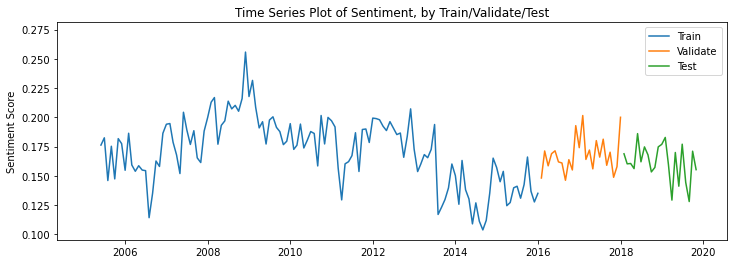

In [105]:
# a visualization of the three tsa splits
plt.figure(figsize=(12,4))
plt.plot(tsa_train.resample('M').vader.mean())
plt.plot(tsa_validate.resample('M').vader.mean())
plt.plot(tsa_test.resample('M').vader.mean())
plt.ylabel('Sentiment Score')
plt.title('Time Series Plot of Sentiment, by Train/Validate/Test')
plt.legend(labels = ["Train","Validate","Test"])
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

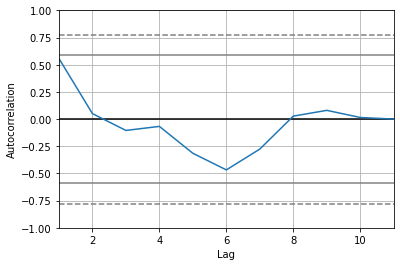

In [106]:
# An autocorrelation plot to visualize seasonality
# The is year over year; when run monthly or  weekly, there is no seasonality to speak of at all
pd.plotting.autocorrelation_plot(tsa_train.resample('y').mean())

- There doesn't look to be any seasonality to speak of--try running the autocorrelation_plot with different resmample lengths
- from the curriculum:
    - "The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise."

In [107]:
# Stats imports for sa analysis
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

<AxesSubplot:xlabel='date'>

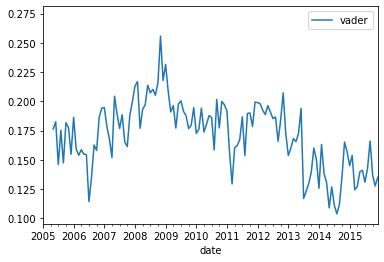

In [108]:
# making sure to clean any unexpected nulls and plot montly vader score
tsa_train.dropna(axis=0, how='any').resample('M').mean().plot()

<AxesSubplot:xlabel='date'>

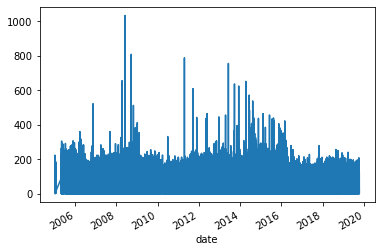

In [109]:
df.utterance_word_count.plot()

-  were there more words uttered in the election years? 2014-2016 at least
- more words in 2009? Are these outliers?

In [110]:
tsa_train[tsa_train.vader.isnull() == True]

,vader
date,


In [111]:
# tsa_train['vader_stopped'] = tsa_train['vader_stopped'].fillna(0)

In [112]:
# sm.tsa.seasonal_decompose(tsa_train.resample('M').mean()).plot()


# _ = sm.tsa.seasonal_decompose(tsa_train['vader_stopped'].resample('W').mean()).plot()


# ValueError: This function does not handle missing values


### Simple Average Model

In [113]:
# math imports for modeling
from sklearn.metrics import mean_squared_error
from math import sqrt

In [114]:
# Create the empty dataframe
tsa_eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_tsa_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return tsa_eval_df.append(d, ignore_index = True)

In [115]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(tsa_validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [116]:
# create a score to add to the yhat df for predictions
score = round(tsa_train['vader'].mean(), 4)

def make_predictions():
    yhat_df = pd.DataFrame({'vader': score}, index = tsa_validate.index)

    return yhat_df

yhat_df = make_predictions()

In [117]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [118]:
# plot and evaluate, slightly altered for one viz
def plot_and_eval_2(target_var,model_type):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(f"{target_var}, {model_type}")
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [119]:
yhat_df.head()

,vader
date,
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774


vader -- RMSE: 0.4786


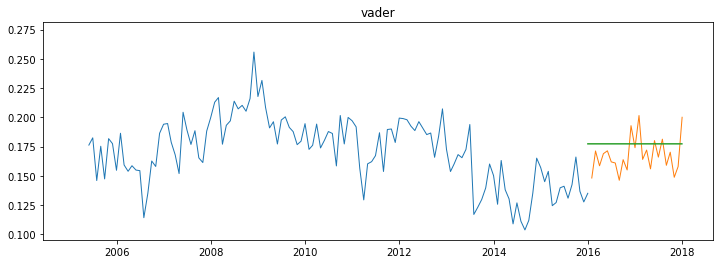

In [120]:
# run plot and eval on the simple avg
plot_and_eval('vader')

In [121]:
# create eval df for tsa simple avg
tsa_eval_df = append_tsa_eval_df(model_type='simple_average', 
                             target_var = 'vader')

In [122]:
tsa_eval_df

,model_type,target_var,rmse
0,simple_average,vader,0.4786


### Moving Average

In [123]:
# train['vader'].rolling(3).mean()

In [124]:
# testing for loop to create periods for below cell
periods = [3, 6, 9, 12]

for p in periods:
    print(str(p) +'M')

3M
6M
9M
12M


vader -- RMSE: 0.4794


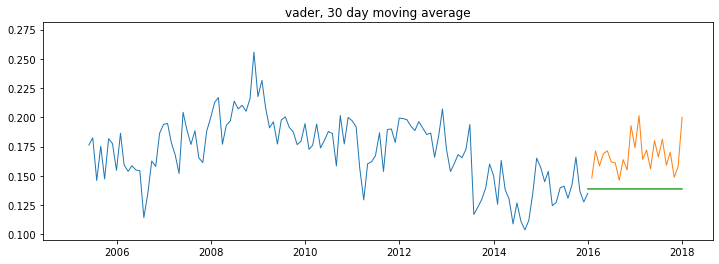

vader -- RMSE: 0.4800


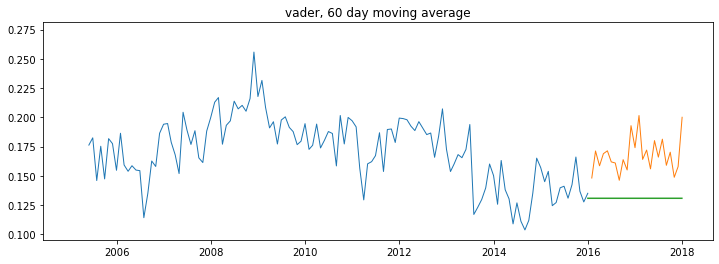

vader -- RMSE: 0.4797


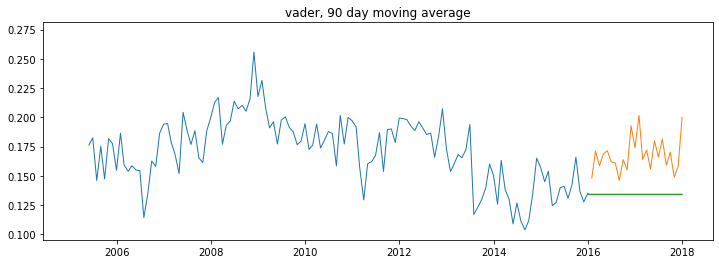

vader -- RMSE: 0.4794


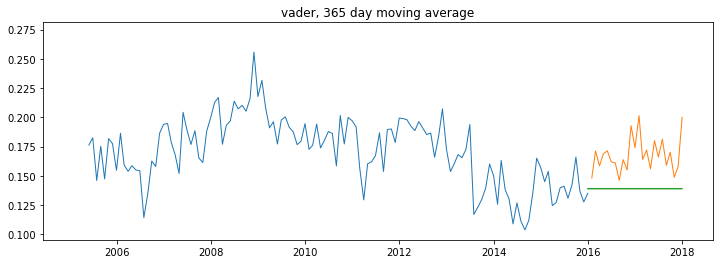

,model_type,target_var,rmse
0,simple_average,vader,0.4786
1,30 day moving average,vader,0.4794
2,60 day moving average,vader,0.4800
3,90 day moving average,vader,0.4797
4,365 day moving average,vader,0.4794


In [125]:
# Plotting rolling averages with different periods
# also returning the eval df

periods = [30, 60, 90, 365]

for p in periods:
    score = round(tsa_train['vader'].rolling(str(p) +'D').mean().iloc[-1], 4)
    yhat_df = make_predictions()
    model_type = str(p) + ' day moving average'
    tsa_eval_df = append_tsa_eval_df(model_type = model_type,
                             target_var = 'vader'
                            )
    plot_and_eval_2('vader', model_type)
tsa_eval_df

- The lowest rmse is on simple average

In [126]:
yhat_df.head()

,vader
date,
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391


#### fixed the problem i was having with the rolling averages


In [127]:
# _ = sm.tsa.seasonal_decompose(train['vader'].resample('W').mean()).plot()
# plt.show()

# Still having problems loooking at seasonl decomposition due to missing valuese

In [128]:
tsa_validate.index[-1]

Timestamp('2017-12-29 00:00:00')

In [129]:
tsa_train['vader'].resample('M').mean()

date
2005-01-31    0.272687
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31    0.176331
                ...   
2015-08-31    0.142616
2015-09-30    0.166131
2015-10-31    0.136887
2015-11-30    0.127784
2015-12-31    0.135150
Freq: M, Name: vader, Length: 132, dtype: float64

In [130]:
# model = Holt(tsa_train['vader'], exponential = False)
# model = model.fit(smoothing_level = .1, 
#                   smoothing_slope = .1, 
#                   optimized = False)
# yhat_items = model.predict(start = tsa_validate.index[0], 
#                            end = tsa_validate.index[-1])
# yhat_df['vader'] = round(yhat_items, 4)

# #HOLTS IS BROKEN : (

# # KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'


In [131]:
# yhat_df.head()
# the above is returning NaNs only

In [132]:
# plot_and_eval('vader')

### Moving prophet model to its own notebook bc of the size of it (not pushing to github)

In [133]:
prophet_results = pd.read_csv('prophet_predictions.csv')
prophet_results.head()

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,0,2005-01-11,0.196414,-0.406567,0.797757,0.196414,0.196414,-0.014257,-0.014257,-0.014257,-0.018087,-0.018087,-0.018087,0.003829,0.003829,0.003829,0.0,0.0,0.0,0.182157
1,1,2005-01-26,0.195177,-0.398178,0.825445,0.195177,0.195177,-0.002493,-0.002493,-0.002493,-0.008524,-0.008524,-0.008524,0.006032,0.006032,0.006032,0.0,0.0,0.0,0.192684
2,2,2005-05-02,0.187257,-0.449237,0.761096,0.187257,0.187257,-0.024833,-0.024833,-0.024833,-0.016592,-0.016592,-0.016592,-0.008242,-0.008242,-0.008242,0.0,0.0,0.0,0.162424
3,3,2005-05-03,0.187174,-0.442981,0.732462,0.187174,0.187174,-0.026075,-0.026075,-0.026075,-0.018087,-0.018087,-0.018087,-0.007989,-0.007989,-0.007989,0.0,0.0,0.0,0.161099
4,4,2005-05-04,0.187092,-0.416686,0.778064,0.187092,0.187092,-0.016162,-0.016162,-0.016162,-0.008524,-0.008524,-0.008524,-0.007638,-0.007638,-0.007638,0.0,0.0,0.0,0.170930


In [134]:
yhat_df = prophet_results[['ds','yhat']].rename(columns={'yhat':'vader', 'ds':'date'})
yhat_df.date = pd.to_datetime(yhat_df.date)
yhat_df = yhat_df.set_index('date').sort_index()
# yhat_df =  yhat_df.set_index('ds')#.sort_values(by=yhat_df.index)
yhat_df = yhat_df[2016:2017]
yhat_df.shape

(1, 1)

In [135]:
# create eval df for tsa simple avg
# tsa_eval_df = append_tsa_eval_df(model_type='prophet', target_var = 'vader')

In [136]:
# plot_and_eval('yhat')

## The confidence intervals on the Prophet model were massive.  The sentiment observations in this data are very close together and yield rather little predictive power

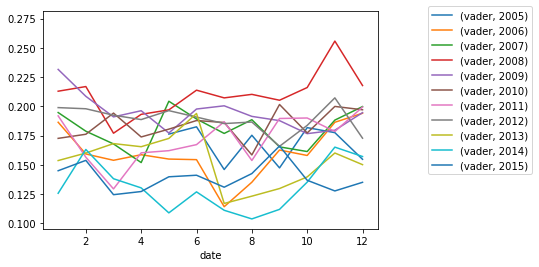

In [137]:
# average sentiment over the course of each years
tsa_train.groupby([tsa_train.index.year, tsa_train.index.month]).mean().unstack(0).plot()
plt.legend(loc=(1.3,.5), bbox_to_anchor=(0.5, 0., 0.5, 0.5))

- Is there a trend of dipping sentiment in the summer?
- Also, it seems like the vader scores are lower in the later years

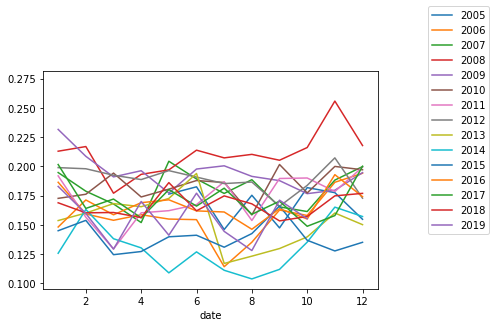

In [138]:
# the same, but on the whole df (not just train)
df.groupby([df.index.year, df.index.month]).mean().unstack(0).vader.plot()
plt.legend(loc=(1.3,.5), bbox_to_anchor=(0.5, 0., 0.5, 0.5))

- Those sentiment scores were lower in '14 and '15, but came back up in the subsequent years

# MODELING

# refer to my modeling notebook